# Prophet

Time serie forecasting using Prophet

Official documentation: https://facebook.github.io/prophet/docs/quick_start.html

Procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It is released by Facebook’s Core Data Science team.

Additive model is a model like:  
$Data = seasonal\space effect + trend + residual$

and, multiplicative model:  
$Data = seasonal\space effect * trend * residual$

The algorithm provides useful statistics that help visualize the tuning process, e.g. trend, week trend, year trend and their max and min errors.

### Data

The data on which the algorithms will be trained and tested upon comes from Kaggle Hourly Energy Consumption database. It is collected by PJM Interconnection, a company coordinating the continuous buying, selling, and delivery of wholesale electricity through the Energy Market from suppliers to customers in the reagon of South Carolina, USA. All .csv files contains rows with a timestamp and a value. The name of the value column corresponds to the name of the contractor. the timestamp represents a single hour and the value represents the total energy, cunsumed during that hour.

The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

https://www.kaggle.com/robikscube/hourly-energy-consumption

Pulling the PJM East which has data from 2002-2018 for the entire east region.



In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

In [5]:
dataset_path = './data/hourly-energy-consumption/PJME_hourly.csv'
df = pd.read_csv(dataset_path, index_col=[0], parse_dates=[0])
print("Dataset path:",df.shape)
df.head(10)

Dataset path: (145366, 1)


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2002-12-31 06:00:00,26222.0
2002-12-31 07:00:00,28702.0
2002-12-31 08:00:00,30698.0
2002-12-31 09:00:00,31800.0


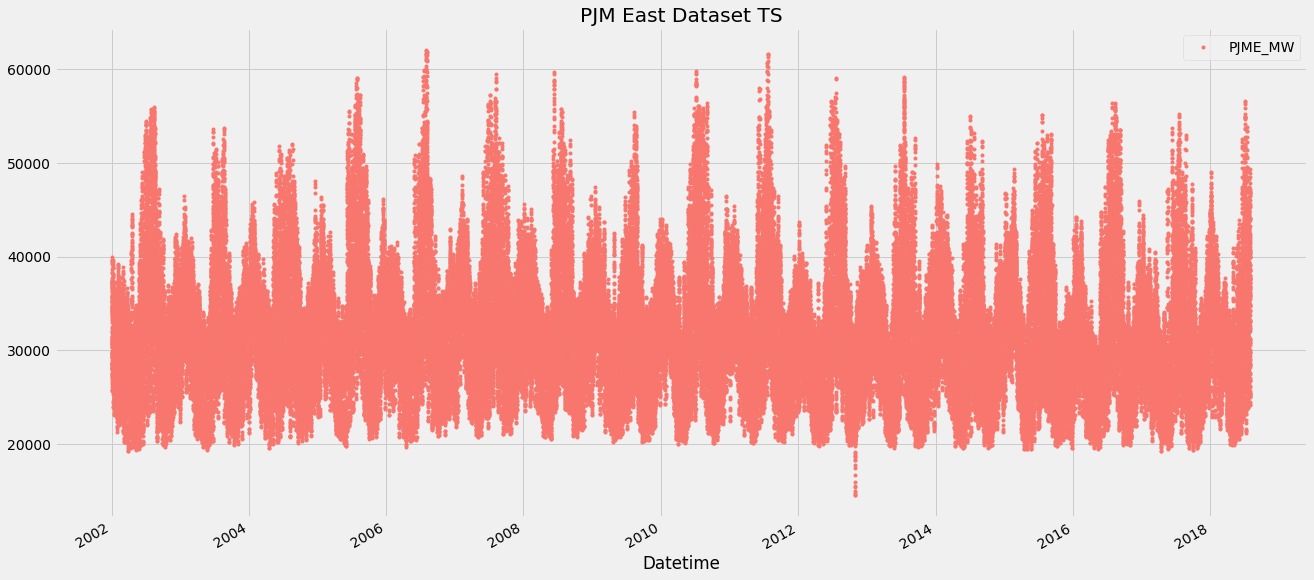

In [6]:
# VISUALIZE DATA
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
df.plot(style='.', figsize=(20,10), color=color_pal[0], title='PJM East Dataset TS')
plt.show()

In [7]:
#Decompose the seasonal data

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [8]:
df.columns

Index(['PJME_MW'], dtype='object')

In [9]:
X, y = create_features(df, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

print("Shape",features_and_target.shape)
features_and_target.head(10)

Shape (145366, 9)


,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0
2002-12-31 06:00:00,6,1,4,12,2002,365,31,1,26222.0
2002-12-31 07:00:00,7,1,4,12,2002,365,31,1,28702.0
2002-12-31 08:00:00,8,1,4,12,2002,365,31,1,30698.0
2002-12-31 09:00:00,9,1,4,12,2002,365,31,1,31800.0


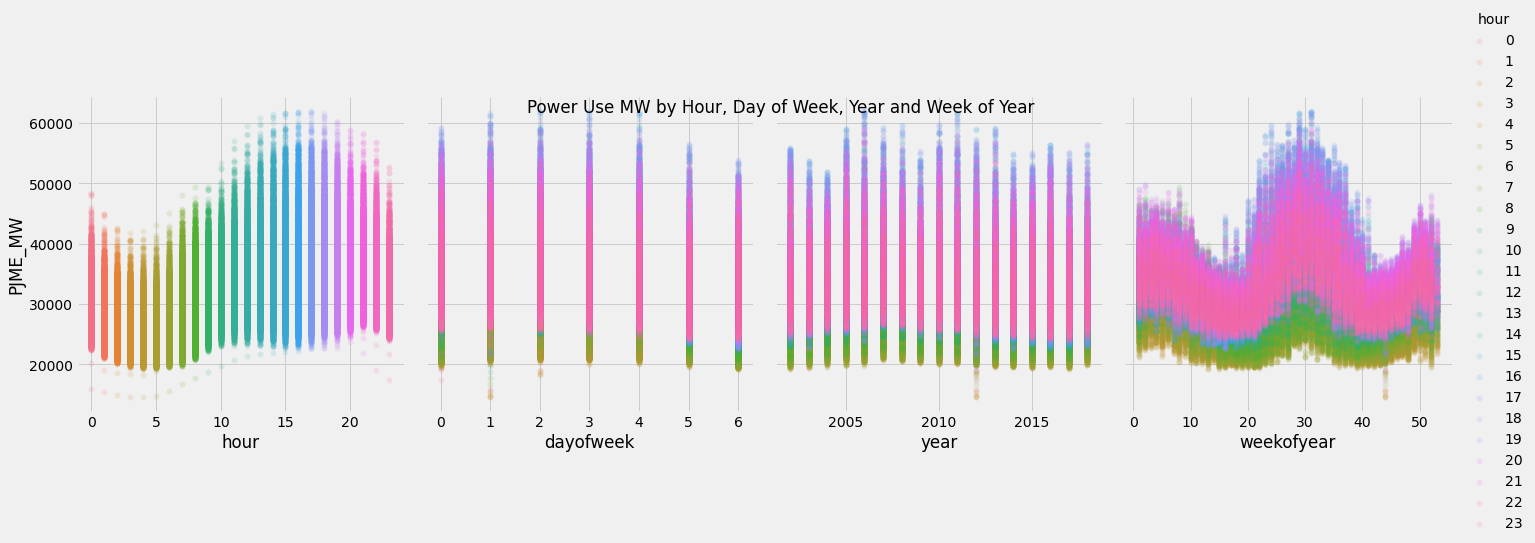

In [10]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

## Train and Test Split

We use a temporal split, keeping old data and use only new period to do the prediction

In [11]:
split_date = '01-Jan-2015'
pjme_train = df.loc[df.index <= split_date].copy()
pjme_test = df.loc[df.index > split_date].copy()

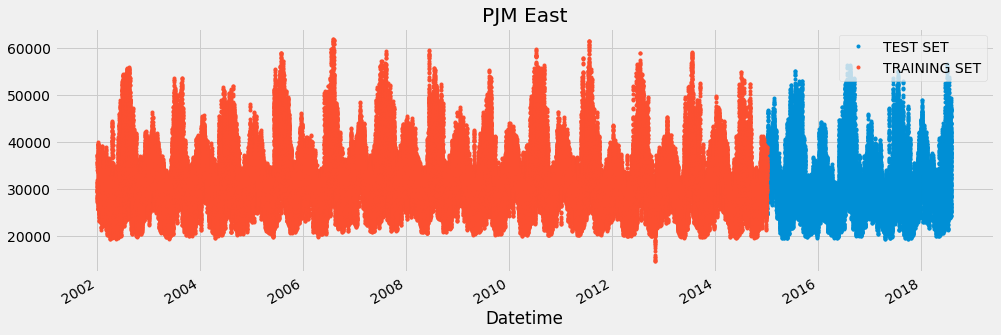

In [12]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

To use prophet you need to correctly rename features and label to correctly pass the input to the engine.

In [13]:
# Format data for prophet model using ds and y
pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

print(pjme_train.columns)
pjme_train.head(5)

Index(['PJME_MW'], dtype='object')


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


### Create and train the model

In [14]:
# Setup and train model and fit
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'}))


In [15]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [16]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31207.063831,24005.881573,32731.510950,31207.063831,31207.063831,-2868.419002,-2868.419002,-2868.419002,-4430.402129,...,1281.405218,1281.405218,1281.405218,280.577909,280.577909,280.577909,0.0,0.0,0.0,28338.644829
1,2015-01-01 02:00:00,31207.026202,22620.918523,31233.681616,31207.026202,31207.026202,-4372.817968,-4372.817968,-4372.817968,-5927.333427,...,1272.645796,1272.645796,1272.645796,281.869663,281.869663,281.869663,0.0,0.0,0.0,26834.208234
2,2015-01-01 03:00:00,31206.988572,21441.421645,30334.540555,31206.988572,31206.988572,-5244.525171,-5244.525171,-5244.525171,-6790.408686,...,1262.680591,1262.680591,1262.680591,283.202924,283.202924,283.202924,0.0,0.0,0.0,25962.463401
3,2015-01-01 04:00:00,31206.950943,21411.559381,30365.227612,31206.950943,31206.950943,-5386.074750,-5386.074750,-5386.074750,-6922.285681,...,1251.633212,1251.633212,1251.633212,284.577718,284.577718,284.577718,0.0,0.0,0.0,25820.876192
4,2015-01-01 05:00:00,31206.913313,21786.069031,30791.338914,31206.913313,31206.913313,-4711.729010,-4711.729010,-4711.729010,-6237.362560,...,1239.639481,1239.639481,1239.639481,285.994069,285.994069,285.994069,0.0,0.0,0.0,26495.184303


### Plot the results and forecast

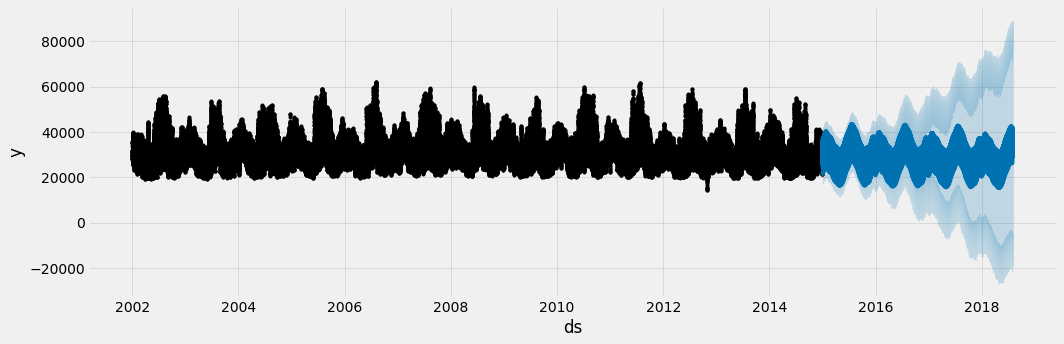

In [17]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

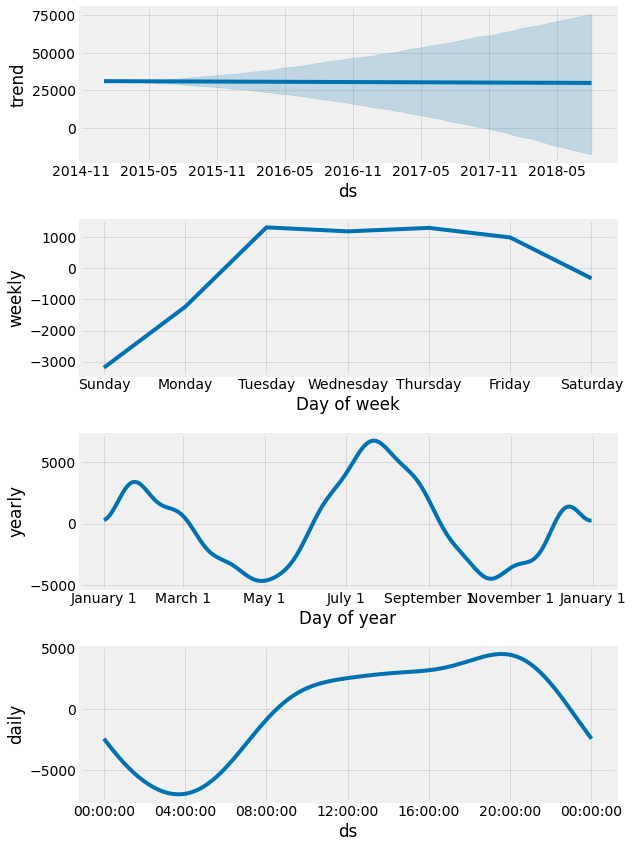

In [18]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)